In our 4th group meeting, Rifat mentioned an interesting [paper](https://proceedings.neurips.cc/paper_files/paper/2023/file/88dddaf430b5bc38ab8228902bb61821-Paper-Conference.pdf) titled "Large language models implicitly learn to straighten neural sentence trajectories to construct a predictive representation of natural language". This paper introduces a measure of "curvature" between adjacent words in a sentence. The plot of curvature vs layer looks very similar to what we observed in our plot of entropy/MI vs layer. In fact, it should be possible to rewrite $\alpha=2$ entropy in terms of this curvature using the arc-cosine kernel. This notebook will prove that, then have some experiments comparing curvature and entropy.

Authors: Oscar Skean

# Curvature

Our definition of k-curvature is given by the following:

\begin{equation}
\tag{k-curvature}
c_{i, k}^p = \arccos \left( \frac{v_{i+k}^p v_i^p}{|v_{i+k}^p||v_i^p|} \right)
\end{equation}

We have that $p$ is a layer in the llm, and $v_{j}$ is the j-th token vector at layer $p$. $k$ is an offset between the two vectors we are comparing. If $k=1$, as in the paper, then we are comparing adjacent words. The average k-curvature over a sentence is a useful measure, given by:

\begin{equation}
\tag{average k-curvature}
C_{k}^p = \frac{1}{N} \sum_{i=1}^N c_{i, k}^p
\end{equation}

# Rewriting Matrix-based Entropy as Curvature

We will now show that matrix-based entropy, at $\alpha=2$, is related to a sum over all k-curvatures. To begin thinking about this, we begin with an example where $N=4$ and arrange the curvatures into a $NxN$ matrix as such:

\begin{equation}
\tag{Layer p curvature matrix}

K_p(V) = 
\begin{bmatrix} 
    \color{red}{c_{1, 0}^p} & \color{green}{c_{1, 1}^p} & \color{cyan}{c_{1, 2}^p} & \color{yellow}{c_{1, 3}^p} \\
    \color{green}{c_{2, 1}^p} & \color{red}{c_{2, 0}^p} & \color{green}{c_{2, 1}^p} & \color{cyan}{c_{2, 2}^p} \\
    \color{cyan}{c_{3, 2}^p} & \color{green}{c_{3, 1}^p} & \color{red}{c_{3, 0}^p} & \color{green}{c_{3, 1}^p} \\
    \color{yellow}{c_{4, 3}^p} & \color{cyan}{c_{4, 2}^p} & \color{green}{c_{4, 1}^p} & \color{red}{c_{4, 0}^p} \\
    \end{bmatrix}
\end{equation}

Each diagonal captures the sentence curvature for a specific $k$. For example, the green off-diagonal, where $k=1$ for all elements, captures the adjacent word curvature that was analyzed in the paper. The red diagonal is constant and not very important. However, it might be said that that the cyan/yellow diagonals are equally imporant to the green diagonal and capture long-distance information that the green diagonal fails to capture. The matrix-based entropy measure, which summarizes the *entire* matrix, will capture information about each diagonal. 

Recall that when $\alpha=2$, matrix-based entropy is given by the kernel Frobenius norm as:

\begin{equation}
\tag{$\alpha$=2 entropy}

S_{2}(K) = \frac{1}{1-\alpha} \log \left( \sum_i^N \frac{\lambda_i^2}{\textrm{tr}(K)} \right) = \frac{1}{1-\alpha} \log \left( ||K||_F^2 \right)

\end{equation}

Next, lets choose K to be the arc-cosine kernel given by $k(v_i, v_{i+k}) = 1 - \frac{1}{\pi} \arccos(\frac{v_i^T v_{i+k}}{|v_i||v_{i+k}|}) = 1 - \frac{c_{i, k}^p}{\pi}$. This so-called arc-cosine kernel is well studied (see [this](https://arxiv.org/pdf/1112.3712) for example). To be continued

# Experiments

In [43]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import numpy as np
import tqdm
from utils import get_model_path, get_dataloader, normalize
import repitl.matrix_itl as itl
import math

device = "cuda:1"

In [64]:
def calculate_paired_curvature(a, b):
    # these vectors should already have unit norm
    return torch.arccos(a.T @ b).item()


def calculate_layer_average_k_curvature(layer_p_embeddings, k=1):
    summation, counter = 0, 0

    while (counter+k) < layer_p_embeddings.shape[0]:
        summation += calculate_paired_curvature(layer_p_embeddings[counter,:], layer_p_embeddings[counter+k,:])
        counter += 1

    summation /= counter
    return summation

def calculate_model_k_curvature(model, dataloader, k=1):
    curvature_list = []
    counter = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=300):
            counter+=1
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            N, D = outputs.hidden_states[0].shape[1:]


            layer_embeddings_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
            layer_curvatures = [calculate_layer_average_k_curvature(layer_p, k=k)/math.log(D) for layer_p in layer_embeddings_list]
            curvature_list.append(layer_curvatures)

            if counter>300:
                break

    return curvature_list

In [57]:
def calculate_model_layer_entropy(model, dataloader, alpha=2):
    entropy_list = []
    counter = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=300):
            counter += 1
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            N, D = outputs.hidden_states[0].shape[1:]
            
            B_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
            B_cov_list = []
            for B in B_list:
                B = B.squeeze()
                if N > D:
                    B_cov = B.T @ B
                else:
                    B_cov = B @ B.T
                B_cov /= torch.trace(B_cov)
                B_cov = torch.clamp(B_cov, min=0)
                B_cov_list.append(B_cov)

            B_entropy_list = []
            for B_cov in B_cov_list:
                entropy_B = itl.matrixAlphaEntropy(B_cov, alpha=alpha).item() / (math.log(N)*math.log(D))
                B_entropy_list.append(entropy_B)

            entropy_list.append(B_entropy_list)
            if counter > 300:
                break

    return entropy_list

In [68]:
k_list = [1, 2, 5]
average_layer_curvature = {}
average_layer_entropy = {}

for model_size in ['70m', '160m', '410m']:
    model_path = get_model_path("EleutherAI", model_size)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path, output_hidden_states=True).to("cuda:1")
    dataloader = get_dataloader(tokenizer, "wikitext", split="train", min_length=50)
    
    print(f"getting entropy for {model_size}")
    average_layer_entropy[model_size] = np.array(calculate_model_layer_entropy(model, dataloader, alpha=2)).mean(axis=0)
    
    average_layer_curvature[model_size] = {}
    for k in k_list:
        print(f"getting curvature for {model_size} at k={k}")
        average_layer_curvature[model_size][k] = np.array(calculate_model_k_curvature(model, dataloader, k=k)).mean(axis=0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


getting entropy for 70m


100%|██████████| 300/300 [00:02<00:00, 127.98it/s]


getting curvature for 70m at k=1


100%|██████████| 300/300 [00:16<00:00, 18.08it/s]


getting curvature for 70m at k=2


100%|██████████| 300/300 [00:16<00:00, 18.26it/s]


getting curvature for 70m at k=5


100%|██████████| 300/300 [00:16<00:00, 18.57it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


getting entropy for 160m


100%|██████████| 300/300 [00:04<00:00, 71.11it/s]


getting curvature for 160m at k=1


100%|██████████| 300/300 [00:32<00:00,  9.13it/s]


getting curvature for 160m at k=2


100%|██████████| 300/300 [00:32<00:00,  9.17it/s]


getting curvature for 160m at k=5


100%|██████████| 300/300 [00:32<00:00,  9.36it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


getting entropy for 410m


100%|██████████| 300/300 [00:08<00:00, 36.30it/s]


getting curvature for 410m at k=1


100%|██████████| 300/300 [01:04<00:00,  4.62it/s]


getting curvature for 410m at k=2


100%|██████████| 300/300 [01:04<00:00,  4.65it/s]


getting curvature for 410m at k=5


100%|██████████| 300/300 [01:03<00:00,  4.73it/s]


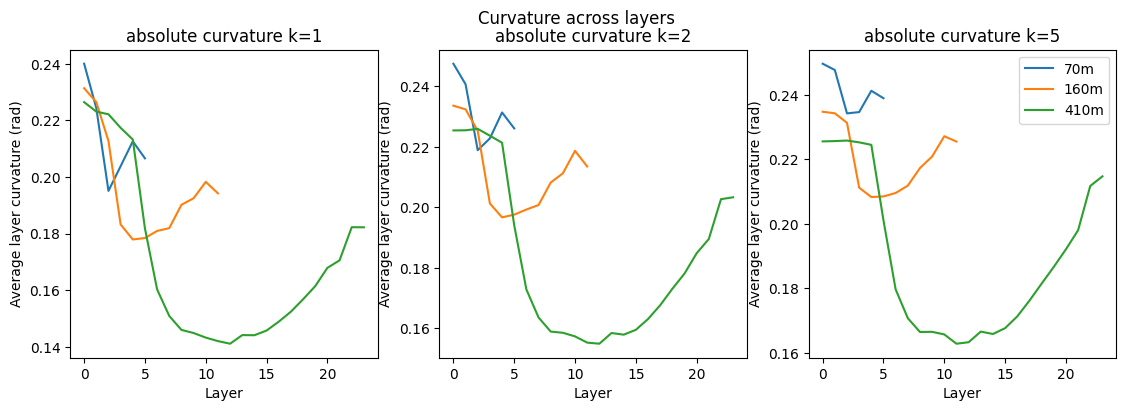

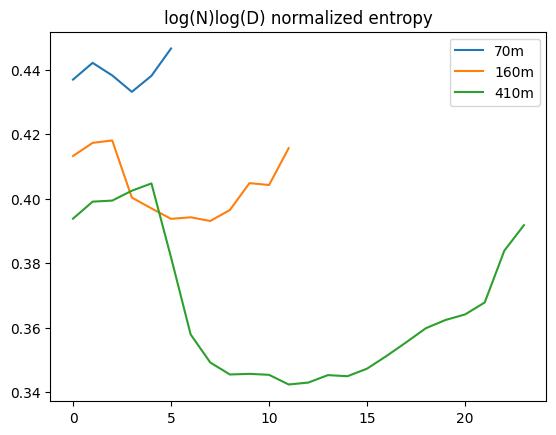

In [69]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1,len(k_list), figsize=(len(k_list)*4.5, 4))
model_sizes = ['70m', '160m','410m']

for k_idx, k in enumerate(k_list):
    for model_size in model_sizes:
        axes[k_idx].plot(average_layer_curvature[model_size][k], label=model_size)
    axes[k_idx].set_title(f"absolute curvature k={k}")
    axes[k_idx].set_xlabel("Layer")
    axes[k_idx].set_ylabel("Average layer curvature (rad)")
axes[-1].legend()
fig.suptitle("Curvature across layers")
plt.show()

for model_size in model_sizes:
    plt.plot(average_layer_entropy[model_size], label=model_size)
plt.title('log(N)log(D) normalized entropy')
plt.legend()
plt.show()